In [1]:
############################################
# Plotting boilerplate
from matplotlib.rcsetup import cycler
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


standard_colors = [
    c["color"] for c in plt.style.library["std-colors"]["axes.prop_cycle"]
]
crest_colors = lambda n: list(sns.color_palette("crest", n_colors=n))
flare_colors = lambda n: list(sns.color_palette("flare", n_colors=n))
circular_colors = lambda n: list(sns.color_palette("husl", n_colors=n))


plt.style.library["science"]["axes.prop_cycle"] = cycler(color=circular_colors(8))
plt.style.use("science")
# figure size in inches, use golden ratio
matplotlib.rcParams["figure.figsize"] = (4.85, 3)
matplotlib.rcParams["figure.dpi"] = 200
# default figure.dpi: 200


def plot(
    fn,
    *fn_args,
    title=None,
    legend=None,
    xlabel=None,
    ylabel=None,
    rotate: int = None,
    **fn_kwargs,
):
    # plt.plot(*line2_xy)
    ret = fn(*fn_args, **fn_kwargs)

    if legend is not None:
        plt.legend() if legend is True else plt.legend(legend)

    if rotate is not None:
        # rotate xlabels by `rotate` degrees`
        plt.setp(
            plt.gca().get_xticklabels(), rotation=rotate, horizontalalignment="right"
        )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return ret


def confidence(x, y, y_err, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.fill_between(x, y + y_err, y - y_err, alpha=0.2, label="_")


def correlation(*args, **kwargs):
    if kwargs.get("figsize") is None:
        kwargs["figsize"] = (9, 11)
    plt.figure(figsize=kwargs["figsize"])
    kwargs.pop("figsize")

    if kwargs.get("cmap") is None:
        kwargs["cmap"] = sns.diverging_palette(230, 20, as_cmap=True)
    if kwargs.get("mask") is None:
        kwargs["mask"] = np.triu(np.ones_like(args[0], dtype=bool))
    if isinstance(kwargs["mask"], bool) and kwargs["mask"] == False:
        kwargs["mask"] = None

    plot(sns.heatmap, *args, **kwargs)
    plt.gca().tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
        labelleft=True,
        labelbottom=True,
    )
    plt.minorticks_off()


np.set_printoptions(precision=4, suppress=True)

# plt.style.library["science"]
########################################3

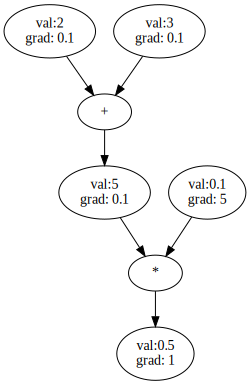

In [2]:
from main import Value, visualize


# Example usage
a = Value(2)
b = Value(3)
c = a + b
d = c * Value(.1)
d.backward()

visualize(d)

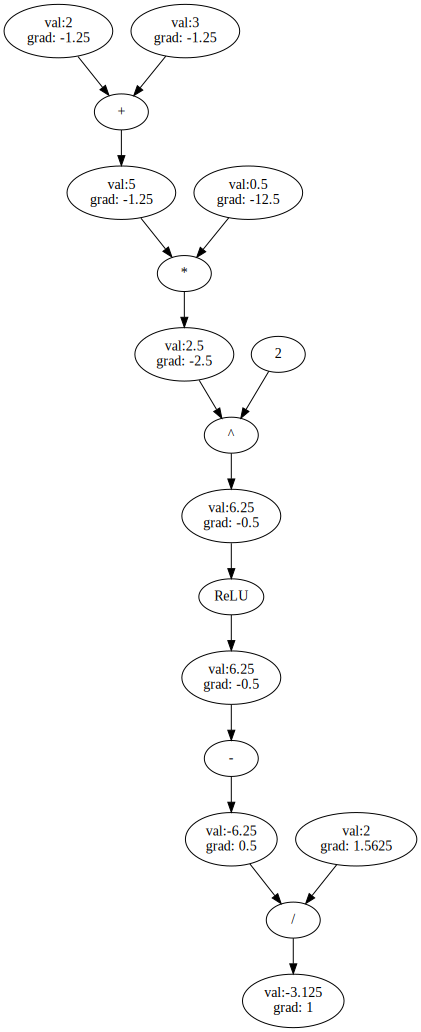

In [3]:
# Example usage
a = Value(2)
b = Value(3)
c = a + b
d = c * Value(0.5)
e = d**2
f = e.relu()
g = -f
h = g / Value(2)
h.backward()

visualize(h)

#! problem: regular float/int basic operations is not supported

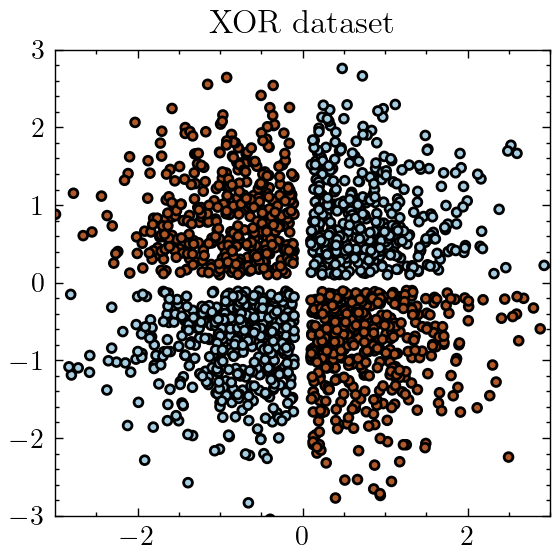

In [4]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(2000, 2)

# remove X if it either axes is too close to 0
X = X[np.abs(X[:, 0]) > .1]
X = X[np.abs(X[:, 1]) > .1]

Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
Y = (Y - .5) * 2

# fit the model
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], s=10, c=Y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.axis([-3, 3, -3, 3])
plt.title(
    "XOR dataset",
    fontsize=12,
)

plt.tight_layout()
plt.show()

In [13]:
import math
import random


class MLP:
    def __init__(self, input_size=2, hidden_size=16, output_size=1, nlayers=2):
        self.layers = []

        # Input layer to first hidden layer
        self.layers.append(Layer(input_size, hidden_size))

        # Hidden layers
        for _ in range(nlayers - 2):
            self.layers.append(Layer(hidden_size, hidden_size))

        # Output layer
        self.layers.append(Layer(hidden_size, output_size))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = [xi.relu() for xi in layer(x)]
        return self.layers[-1](x)  # No activation on the output layer

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


class Layer:
    def __init__(self, in_features, out_features):
        self.weights = [
            Value(random.normalvariate(0, .01))
            for _ in range(in_features * out_features)
        ]
        self.biases = [Value(0) for _ in range(out_features)]

    def __call__(self, x):
        out = []
        for i in range(len(self.biases)):
            activation = self.biases[i]
            for j, xj in enumerate(x):
                activation = activation + self.weights[i * len(x) + j] * xj
            out.append(activation)
        return out

    def parameters(self):
        return self.weights + self.biases


# Example usage:
def main(X, Y, learning_rate=0.03, epochs=500, batch_size=32, silent=False):
    # Create a simple dataset
    # Create the model
    model = MLP(input_size=2, hidden_size=4, output_size=1, nlayers=2)

    # Training loop

    history = []
    for epoch in range(epochs):
        # Forward pass
        total_loss = Value(0)

        minibatch = random.sample(list(zip(X, Y)), batch_size)
        for x, y in minibatch:
            x = [Value(xi) for xi in x]
            pred = model(x)[
                0
            ]  # Our model outputs a list, so we take the first (and only) element
            loss = (pred - Value(y)) * (pred - Value(y))
            total_loss = total_loss + loss

        # Backward pass
        total_loss = total_loss / Value(batch_size)
        total_loss.backward()

        # Update parameters
        for p in model.parameters():
            p.value -= learning_rate * p.grad
            p.grad = 0  # Reset gradients for next iteration

        if not silent and epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.value}")
        history.append(total_loss.value)
    # TODO add evaluation on validation set

    # Test the model
    if silent:
        return model, history
        
    for x in X[:10]:
        x = [Value(xi) for xi in x]
        pred = model(x)[0].value
        
        print(f"Input: {[xi.value for xi in x]}, Prediction: {pred}")

    return model, history

model, history = main(list(X), list(Y))

Epoch 0, Loss: 1.0000001706464836
Epoch 10, Loss: 0.9842228485784557
Epoch 20, Loss: 0.9976229800087609
Epoch 30, Loss: 0.9993189542619751
Epoch 40, Loss: 0.9941648671662683
Epoch 50, Loss: 0.9886735012270562
Epoch 60, Loss: 1.0093267601456204
Epoch 70, Loss: 0.9371714676594268
Epoch 80, Loss: 0.8756225879687523
Epoch 90, Loss: 0.7579832223081445
Epoch 100, Loss: 0.7129676734589986
Epoch 110, Loss: 0.607619381214529
Epoch 120, Loss: 0.5898440622528747
Epoch 130, Loss: 0.6899006708118607
Epoch 140, Loss: 0.5011680495378972
Epoch 150, Loss: 0.646589258333413
Epoch 160, Loss: 0.6176815349692291
Epoch 170, Loss: 0.6853783509725264
Epoch 180, Loss: 0.5951186017075266
Epoch 190, Loss: 0.6716766748661182
Epoch 200, Loss: 0.6217618230393731
Epoch 210, Loss: 0.628919911781521
Epoch 220, Loss: 0.47424633389036575
Epoch 230, Loss: 0.6827983556758714
Epoch 240, Loss: 0.6836913019275365
Epoch 250, Loss: 0.6635079084567241
Epoch 260, Loss: 0.6783409631261581
Epoch 270, Loss: 0.661705047658297
Epoch 

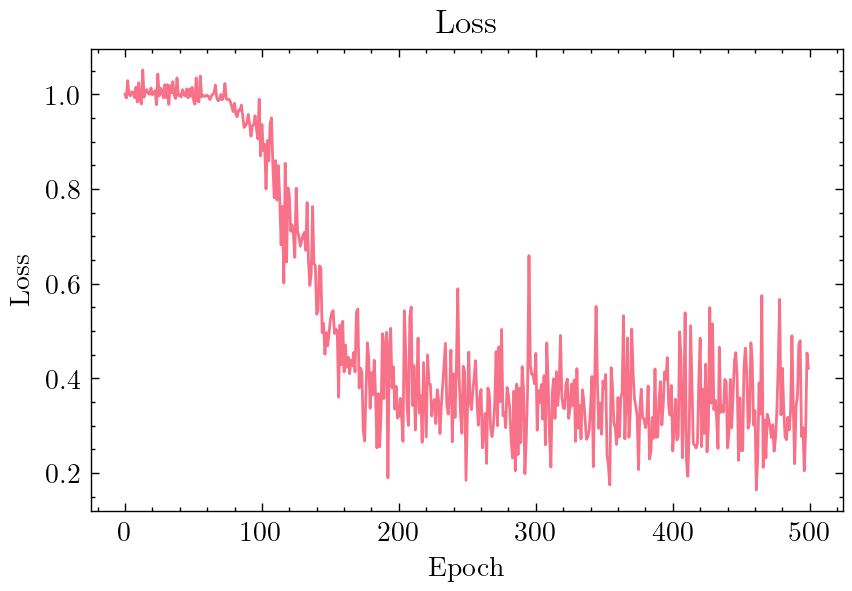

In [6]:
plot(plt.plot, history, title="Loss", xlabel="Epoch", ylabel="Loss")

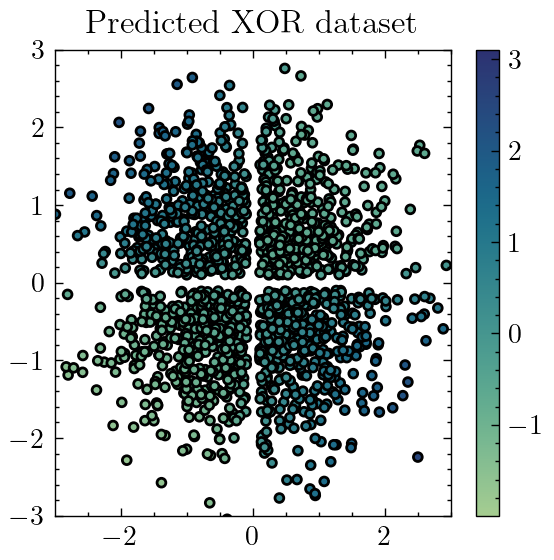

In [7]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

pred = [model([Value(xij) for xij in xi]) for xi in X]
pred = [y[0].value for y in pred]
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)

# fit the model
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], s=10, c=pred, cmap=sns.color_palette("crest", as_cmap=True), edgecolors=(0, 0, 0))
plt.axis([-3, 3, -3, 3])
plt.title(
    "Predicted XOR dataset",
    fontsize=12,
)
plt.colorbar()
plt.tight_layout()
plt.show()

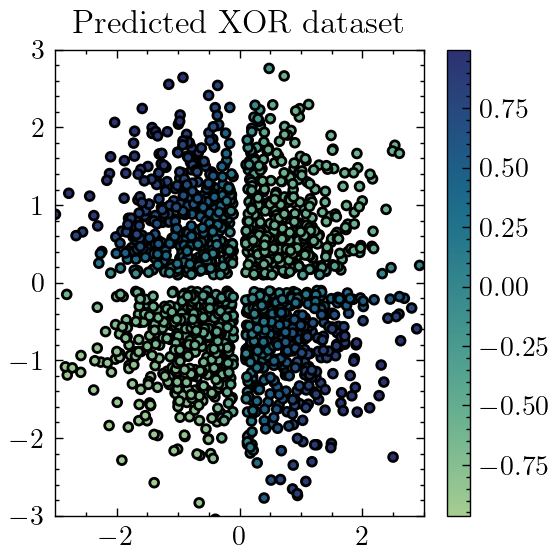

In [8]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

pred = [model([Value(xij) for xij in xi]) for xi in X]
pred = [y[0].value for y in pred]
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)

# fit the model
plt.figure(figsize=(3, 3))
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=10,
    c=np.tanh(np.array(pred)),
    cmap=sns.color_palette("crest", as_cmap=True),
    edgecolors=(0, 0, 0),
)
plt.axis([-3, 3, -3, 3])
plt.title(
    "Predicted XOR dataset",
    fontsize=12,
)
plt.colorbar()
plt.tight_layout()
plt.show()

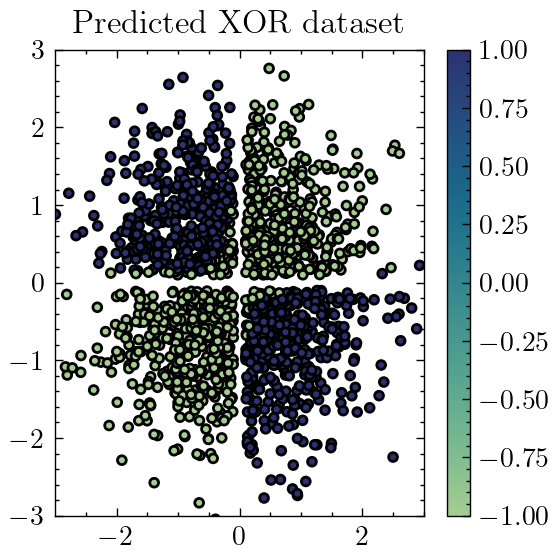

In [9]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

pred = [model([Value(xij) for xij in xi]) for xi in X]
pred = [y[0].value for y in pred]
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)

# fit the model
plt.figure(figsize=(3, 3))
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=10,
    c=np.sign(np.array(pred)),
    cmap=sns.color_palette("crest", as_cmap=True),
    edgecolors=(0, 0, 0),
)
plt.axis([-3, 3, -3, 3])
plt.title(
    "Predicted XOR dataset",
    fontsize=12,
)
plt.colorbar()
plt.tight_layout()
plt.show()

# plot training amount of time as function of nn width


In [15]:
import time

def timeit(fn, *args, **kwargs):
    s = time.time()
    fn(*args, **kwargs)
    end = time.time() - s
    print(f"Time taken: {end:.2f}s")
    return end

repeats = 5
widths = [2, 4, 6, 8, 10]

timings = []
for w in widths:
    print(f"Width: {w}")
    for _ in range(repeats):
        timings.append(timeit(main, list(X), list(Y), silent=True))
    

Width: 2
Time taken: 4.07s
Time taken: 4.72s
Time taken: 4.90s
Time taken: 5.10s
Time taken: 4.83s
Width: 4
Time taken: 5.09s
Time taken: 4.89s
Time taken: 4.64s
Time taken: 4.97s
Time taken: 3.25s
Width: 6
Time taken: 2.84s
Time taken: 2.63s
Time taken: 6.19s
Time taken: 6.67s
Time taken: 8.84s
Width: 8
Time taken: 8.53s
Time taken: 7.12s
Time taken: 5.18s
Time taken: 7.78s
Time taken: 8.40s
Width: 10
Time taken: 7.77s
Time taken: 6.62s
Time taken: 8.30s
Time taken: 8.63s
Time taken: 7.92s


In [19]:
timings = np.array(timings).reshape(-1, repeats)
timings

array([[4.0674, 4.723 , 4.8987, 5.1021, 4.8295],
       [5.0947, 4.8875, 4.6423, 4.9735, 3.2478],
       [2.8396, 2.6338, 6.186 , 6.6698, 8.84  ],
       [8.5268, 7.1249, 5.1812, 7.7848, 8.402 ],
       [7.773 , 6.6181, 8.3045, 8.6254, 7.9235]])

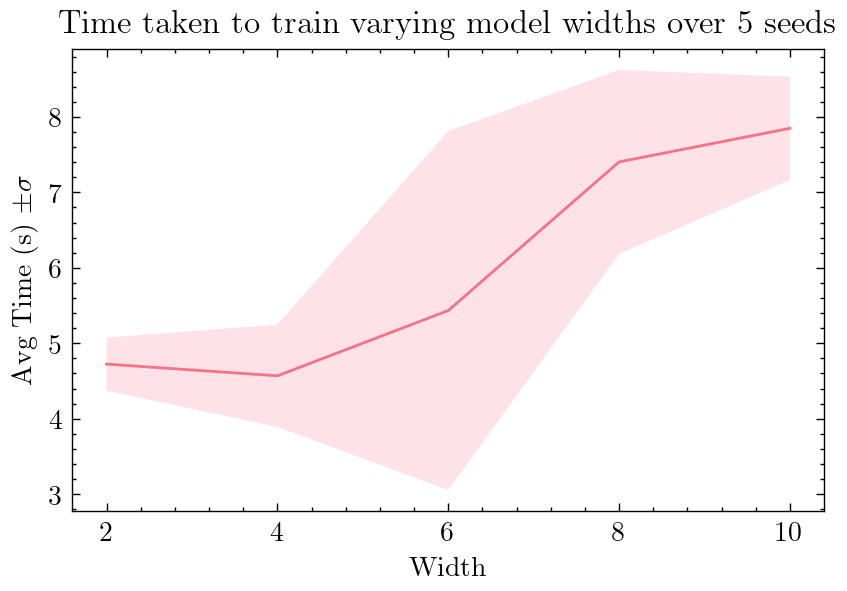

In [29]:
# plot mean and std of timings across different widths

plot(plt.plot, np.mean(timings, axis=1))
plot(plt.fill_between, range(len(widths)), np.mean(timings, axis=1) - np.std(timings, axis=1), np.mean(timings, axis=1) + np.std(timings, axis=1), alpha=0.2, title="Time taken to train varying model widths over 5 seeds", xlabel="Width", ylabel="Avg Time (s) $\pm \sigma$")
# show only the widths actually tested on the x ticks
plt.xticks(range(len(widths)), widths)
plt.show()


# do vectorization


In [41]:
from vectorized_main import VecMLP, VecValue, mse_loss


# Example usage
def vec_main(X, Y):

    # Create the model
    model = VecMLP(input_size=2, hidden_sizes=[8, 8], output_size=1)

    # Training loop
    learning_rate = 0.01
    epochs = 1000

    for epoch in range(epochs):
        # Forward pass
        pred = model(VecValue(X))
        loss = mse_loss(pred, VecValue(Y))

        # Backward pass
        loss.backward()

        # Update parameters
        for p in model.parameters():
            p.data -= learning_rate * p.grad
            p.grad = np.zeros_like(p.grad)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.data}")

    # Test the model
    pred = model(VecValue(X))
    print(f"Final predictions: {pred.data}")


vec_main(X, Y)

ValueError: non-broadcastable output operand with shape (1680,1) doesn't match the broadcast shape (1680,1680)


# plot new training amount of time
